0. Introduction

Our primary objective for this project is to develop a predictive model that evaluates the likelihood of loan default for a specific loan application. We use binary classification algorithms to assess whether a loan should be approved  or declined using historical data obtained from 3 given files. 

We expect that this approach will offer MoneyLion with an understandable and streamlined system for evaluating the risk associated with each loan application in accordance with its specific risk tolerance levels. This strengthened risk assessment capabilities will facilitate data-driven decision-making, empowering MoneyLion to improve its lending strategies and proactively manage risks across its entire portfolio.

1. Import Libraries

In [375]:
import math
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_theme(style='whitegrid', palette='pastel')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn
from utils import *

2. Load Data into DataFrame

In [376]:
loan = pd.read_csv('loan.csv')
payment = pd.read_csv('payment.csv')
underwriting = pd.read_csv('clarity_underwriting_variables.csv', low_memory=False)

3. EDA (Loan)

In [377]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   loanId                            577426 non-null  object 
 1   anon_ssn                          577682 non-null  object 
 2   payFrequency                      576409 non-null  object 
 3   apr                               573760 non-null  float64
 4   applicationDate                   577682 non-null  object 
 5   originated                        577682 non-null  bool   
 6   originatedDate                    46044 non-null   object 
 7   nPaidOff                          577658 non-null  float64
 8   approved                          577682 non-null  bool   
 9   isFunded                          577682 non-null  int64  
 10  loanStatus                        577291 non-null  object 
 11  loanAmount                        575432 non-null  f

In [378]:
#Read Loan Data
loan.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1


In loanStatus variables, we found out the distribution of various loan statuses. The majority of applications were either withdrawn or rejected, followed by paid-off loans values.

In [379]:
loan['loanStatus'].value_counts()

loanStatus
Withdrawn Application          450984
Rejected                        85070
Paid Off Loan                   11427
External Collection             11334
New Loan                         8112
Internal Collection              5567
Returned Item                    1182
CSR Voided New Loan              1026
Settlement Paid Off               708
Credit Return Void                704
Customer Voided New Loan          504
Settled Bankruptcy                326
Pending Paid Off                  169
Charged Off Paid Off              160
Pending Application Fee             5
Pending Rescind                     4
Pending Application                 4
Voided New Loan                     2
Charged Off                         1
Customver Voided New Loan           1
Settlement Pending Paid Off         1
Name: count, dtype: int64

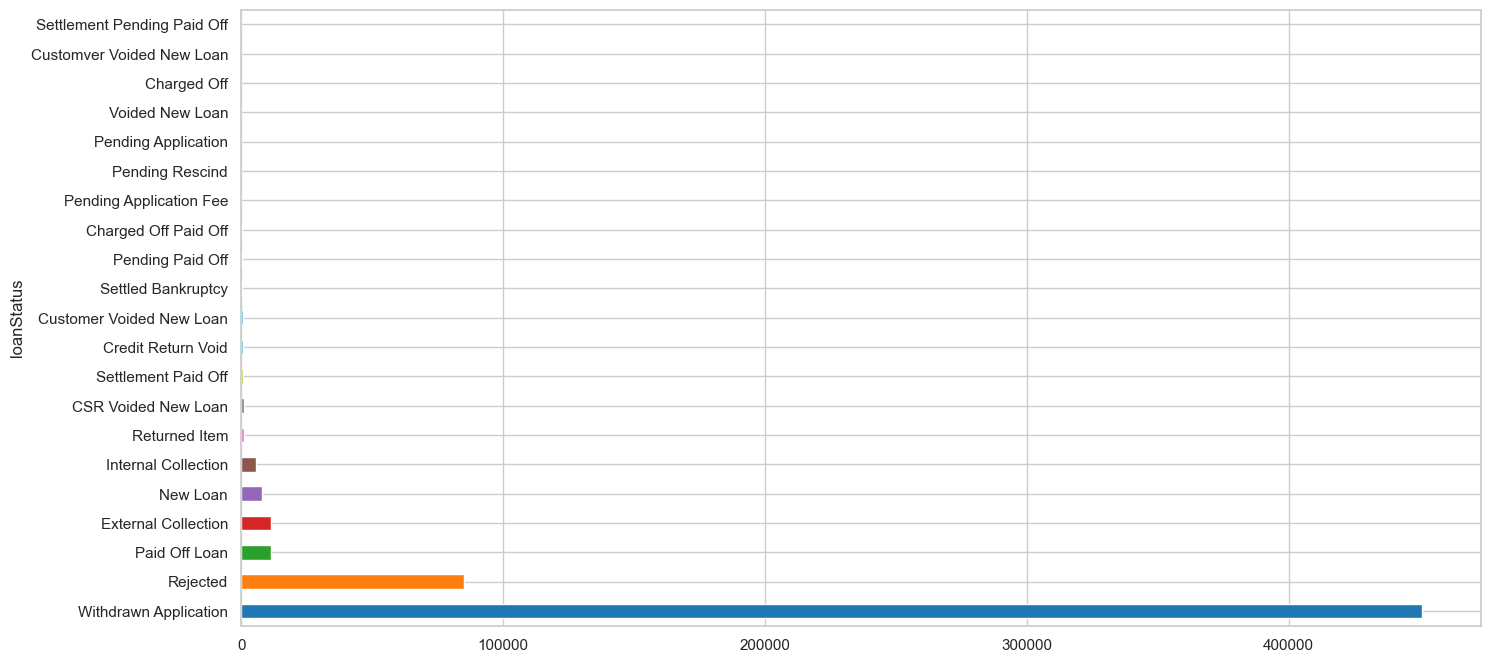

In [380]:
colors = plt.cm.tab10(range(len(loan['loanStatus'].value_counts())))

plt.figure(figsize= (16,8))
plt.xlabel('Loan Status')
plt.ylabel('Count')
loan['loanStatus'].value_counts().plot(kind='barh', grid=True, color=colors)
plt.show()

The variable 'nPaidOff' represents the number of MoneyLion loans paid off by clients in the past. We noted that a significant portion of clients had not paid off any loans, speculating either new customers or those yet to fulfill their payment obligations.

In [381]:
loan['nPaidOff'].value_counts()

nPaidOff
0.0     564599
1.0       8596
2.0       2602
3.0        918
4.0        427
5.0        212
6.0        133
7.0         56
8.0         26
11.0        16
9.0         15
13.0        10
10.0         9
12.0         8
14.0         8
19.0         7
18.0         6
20.0         5
17.0         2
15.0         1
21.0         1
16.0         1
Name: count, dtype: int64

'fpStatus' variable denotes the result of the first payment of the loan. Successful payments ('checked') were the most common, followed by no payment ('loan not funded') and rejections.

In [382]:
loan['fpStatus'].value_counts()

fpStatus
Checked        32978
No Payments    11427
Rejected        5522
No Schedule     1323
Cancelled        249
Skipped          218
Pending            5
Returned           1
Name: count, dtype: int64

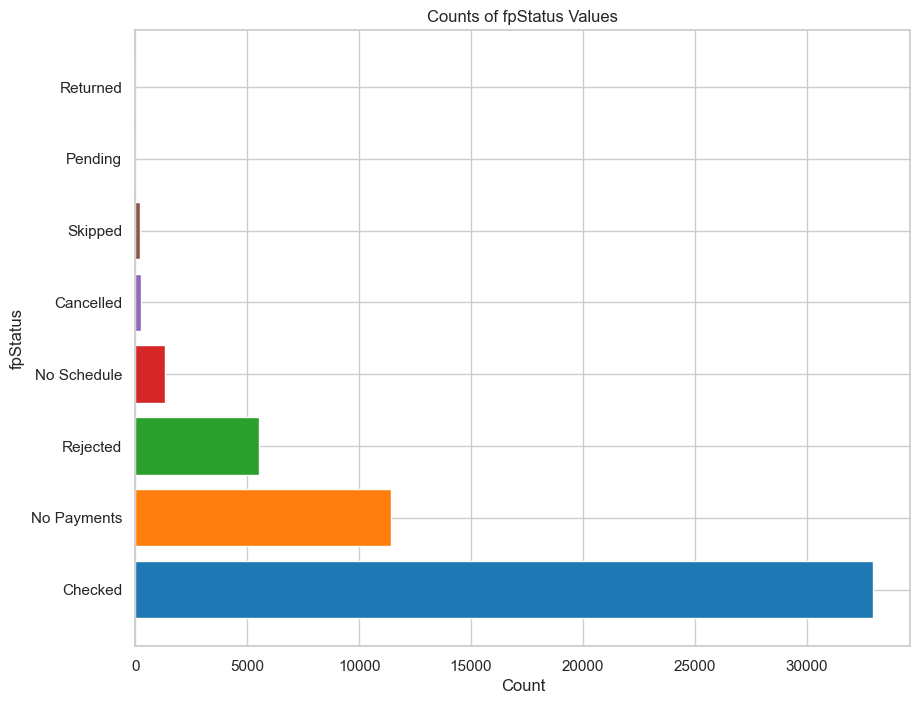

In [383]:
# Data
fpStatus_counts = loan['fpStatus'].value_counts()

# Define colormap
colors = plt.cm.tab10(np.arange(len(fpStatus_counts)))

# Plot
plt.figure(figsize=(10, 8))
plt.barh(fpStatus_counts.index, fpStatus_counts.values, color=colors)
plt.xlabel('Count')
plt.ylabel('fpStatus')
plt.title('Counts of fpStatus Values')
plt.grid(True)
plt.show()

Examining the loan amount through box plots, the interquartile range fell between 0-1000, with more outliers occurring after 1000 dollar.

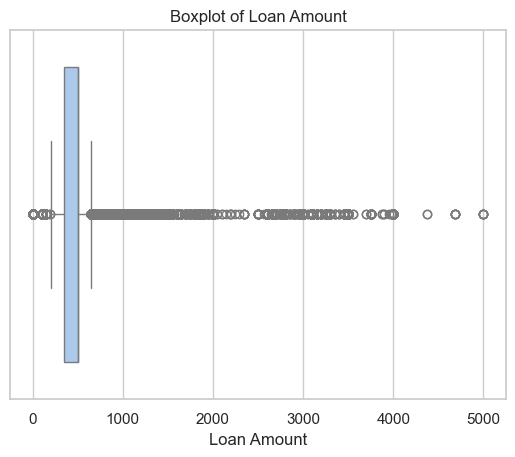

In [384]:
sns.boxplot(x='loanAmount', data=loan, whis=1.0)  # Adjust whis value as needed
plt.title('Boxplot of Loan Amount')
plt.xlabel('Loan Amount')
plt.show()

Based on the contingency table between approval status and funding status, the highest counts of loans applications get rejections and denied funding, while a smaller portion were approved but not yet funded, indicating payments possibly in process.

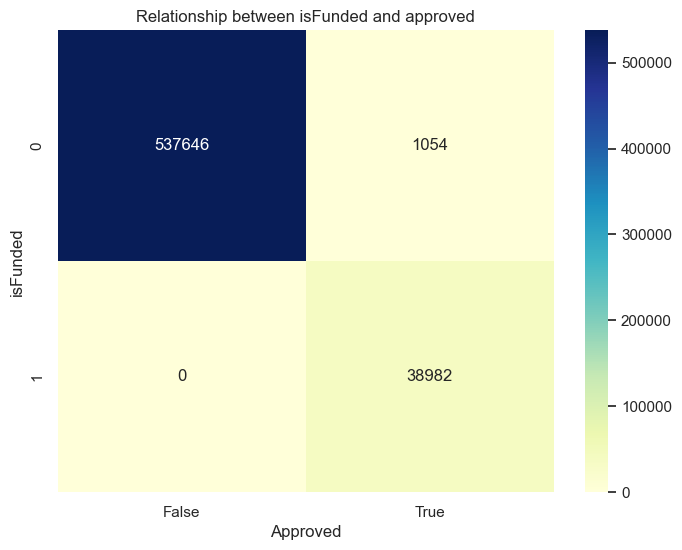

In [385]:
# Create a contingency table (cross-tabulation)
contingency_table = pd.crosstab(loan['isFunded'], loan['approved'])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Relationship between isFunded and approved')
plt.xlabel('Approved')
plt.ylabel('isFunded')
plt.show()

Exploring average loan amounts issued across states, Georgia (GA) had the highest average loan amount issued, followed by New York (NY) and California (CA).

/var/folders/k7/5_vw2hv57dqg7rktjgkx99fc0000gn/T/ipykernel_10784/3330703860.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='loanAmount', y='state', data=loan, palette=palette)
/var/folders/k7/5_vw2hv57dqg7rktjgkx99fc0000gn/T/ipykernel_10784/3330703860.py:5: UserWarning: The palette list has more values (45) than needed (44), which may not be intended.
  sns.barplot(x='loanAmount', y='state', data=loan, palette=palette)


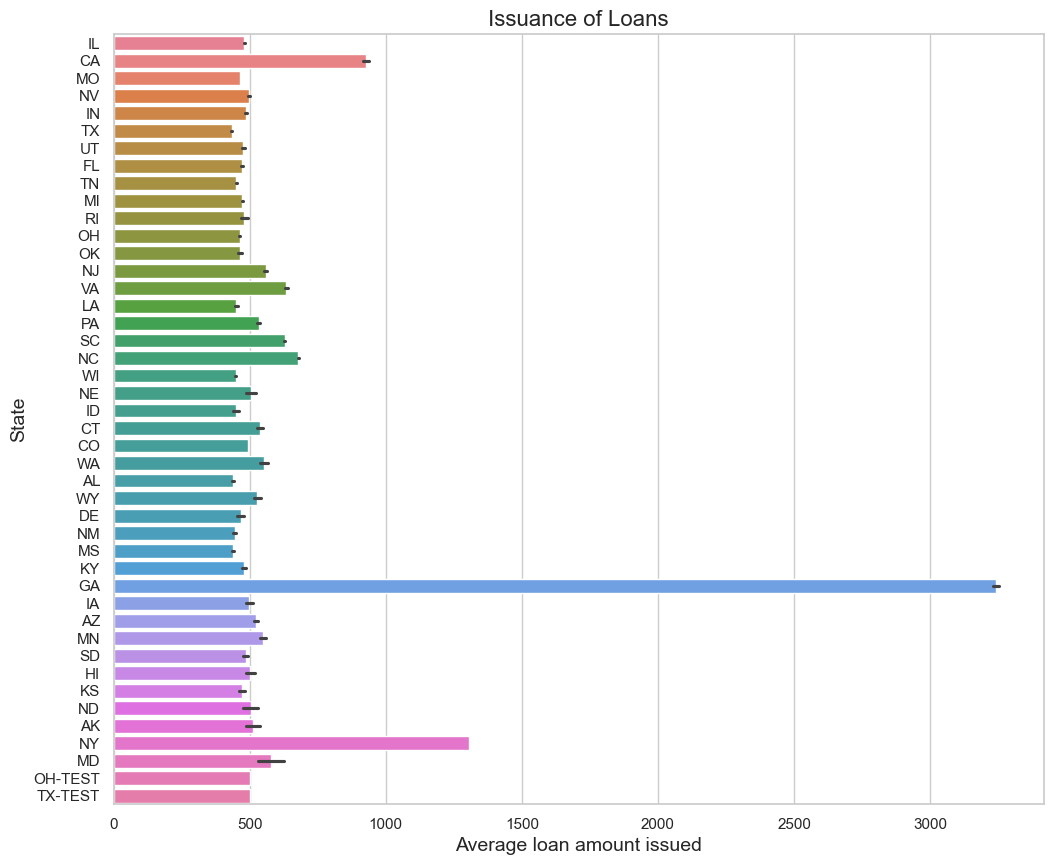

In [386]:
# Define a color palette with different colors
palette = sns.color_palette("husl", len(loan['state'].unique()))

plt.figure(figsize=(12, 10))
sns.barplot(x='loanAmount', y='state', data=loan, palette=palette)
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Average loan amount issued', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.show()

Looking at the distribution of funding statuses across states, Ohio (OH) exhibited the highest denial rate of funding statuses, followed by Illinois (IL) and Missouri (MO).

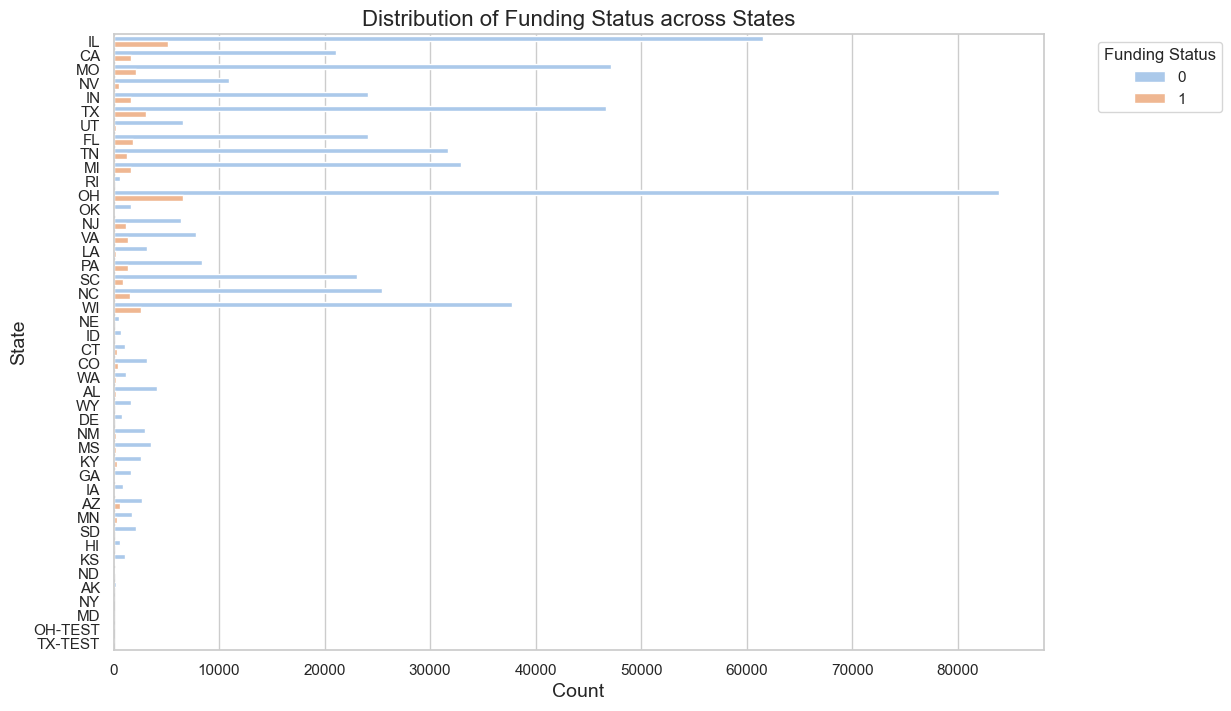

In [387]:
plt.figure(figsize=(12, 8))
sns.countplot(y='state', hue='isFunded', data=loan)
plt.title('Distribution of Funding Status across States', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.legend(title='Funding Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The correlation matrix revealed that the loan APR showed negative correlations with all other variables, while 'originated', 'approved', 'isFunded', 'loanAmount', and 'originallyScheduledPaymentAmount' displayed positive relationships all other variables, except for loan APR. It suggests that changes in the loan APR may have an opposite effect on all the other variables.

In [388]:
numeric_columns = loan.select_dtypes(include=['int64', 'bool', 'float64']).columns
correlation_matrix = loan[numeric_columns].corr()
correlation_matrix

,apr,originated,nPaidOff,approved,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF
apr,1.000000,-0.062596,-0.074328,-0.062880,-0.062981,-0.279014,-0.049065,-0.090854,-0.038632
originated,-0.062596,1.000000,0.251177,0.927619,0.914481,0.113053,0.101958,0.100570,0.141283
nPaidOff,-0.074328,0.251177,1.000000,0.267276,0.269711,0.074269,0.046704,-0.046266,-0.046038
approved,-0.062880,0.927619,0.267276,1.000000,0.985783,0.106731,0.095947,0.090248,0.119974
isFunded,-0.062981,0.914481,0.269711,0.985783,1.000000,0.105397,0.094359,0.085112,0.116856
loanAmount,-0.279014,0.113053,0.074269,0.106731,0.105397,1.000000,0.892881,0.204856,0.178698
originallyScheduledPaymentAmount,-0.049065,0.101958,0.046704,0.095947,0.094359,0.892881,1.000000,0.191381,0.169256
leadCost,-0.090854,0.100570,-0.046266,0.090248,0.085112,0.204856,0.191381,1.000000,0.210834
hasCF,-0.038632,0.141283,-0.046038,0.119974,0.116856,0.178698,0.169256,0.210834,1.000000


EDA (Payment)

In [389]:
payment.head(10)

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked,NaN
1,LL-I-00000021,2,False,2015-01-02T05:00:00,26.44,143.17,169.61,Checked,NaN
2,LL-I-00000021,3,False,2015-01-16T05:00:00,31.30,138.31,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked,NaN
5,LL-I-00000021,6,False,2015-02-27T05:00:00,51.97,117.64,169.61,Checked,NaN
6,LL-I-00000021,7,False,2015-03-13T04:00:00,61.54,108.07,169.61,Checked,NaN
7,LL-I-00000021,8,False,2015-03-27T04:00:00,72.87,96.74,169.61,Checked,NaN
8,LL-I-00000021,9,False,2015-04-10T04:00:00,86.29,83.32,169.61,Checked,NaN
9,LL-I-00000021,10,False,2015-04-24T04:00:00,102.17,67.44,169.61,Rejected,R01


In [390]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689364 entries, 0 to 689363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loanId             689364 non-null  object 
 1   installmentIndex   689364 non-null  int64  
 2   isCollection       689364 non-null  bool   
 3   paymentDate        689364 non-null  object 
 4   principal          689364 non-null  float64
 5   fees               689364 non-null  float64
 6   paymentAmount      689364 non-null  float64
 7   paymentStatus      525307 non-null  object 
 8   paymentReturnCode  31533 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 42.7+ MB


In the payment status variable of the payment dataset, the highest number of occurrences is associated with "cancelled," followed by "checked" (successful) and "rejected."

In [391]:
payment['paymentStatus'].value_counts()

paymentStatus
Cancelled                  270334
Checked                    209621
Rejected                    32330
Pending                      9241
Skipped                      3761
Rejected Awaiting Retry        18
Returned                        1
Complete                        1
Name: count, dtype: int64

The "isCollection" variable in the dataset distinguishes loans with custom-made collection plans ("true") from those without ("false"). There are 13,895 instances of loans with custom-made collection plans and 675,469 instances without.

/var/folders/k7/5_vw2hv57dqg7rktjgkx99fc0000gn/T/ipykernel_10784/2440419556.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='paymentStatus', y='count', data=payment_status_data, palette='pastel')


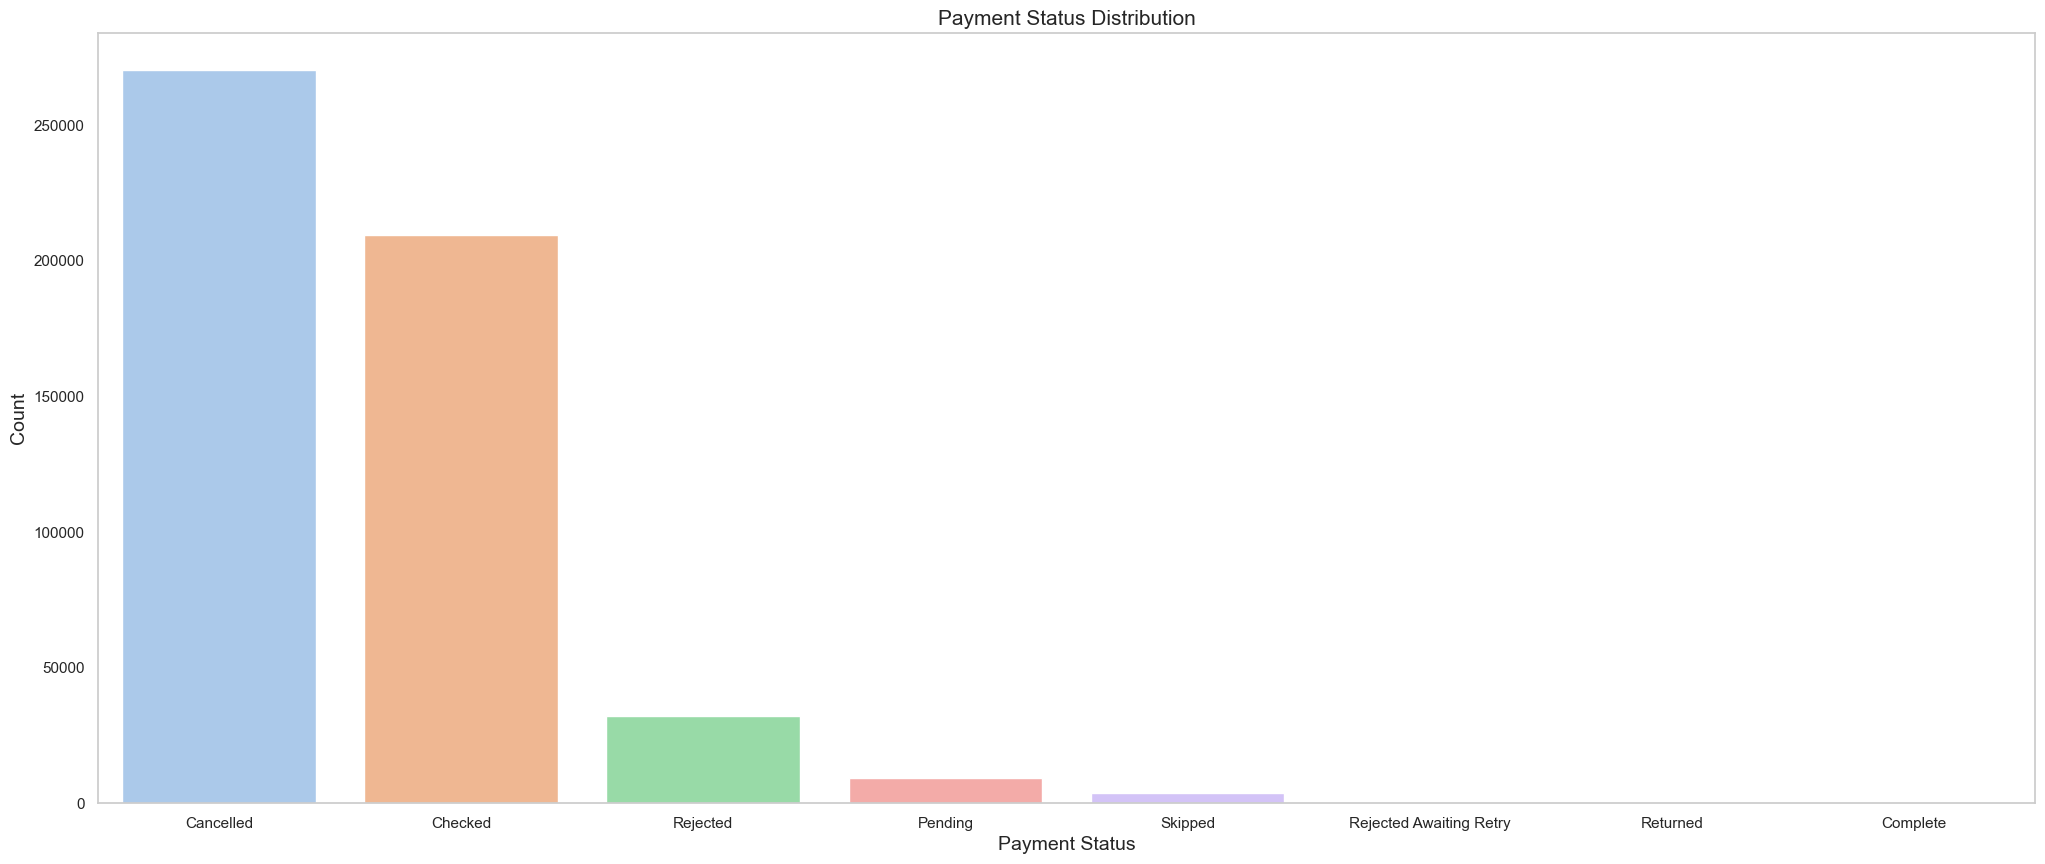

In [392]:
# Assuming payment is your DataFrame containing payment information
payment_status_data = payment['paymentStatus'].value_counts().reset_index()
payment_status_data.columns = ['paymentStatus', 'count']

# Create bar plot
plt.figure(figsize=(25, 10))
sns.barplot(x='paymentStatus', y='count', data=payment_status_data, palette='pastel')
plt.title('Payment Status Distribution', fontsize=15)
plt.xlabel('Payment Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0) 
plt.grid(axis='y')  # Add gridlines to y-axis
plt.show()

In [393]:
payment['isCollection'].value_counts()

isCollection
False    675469
True      13895
Name: count, dtype: int64

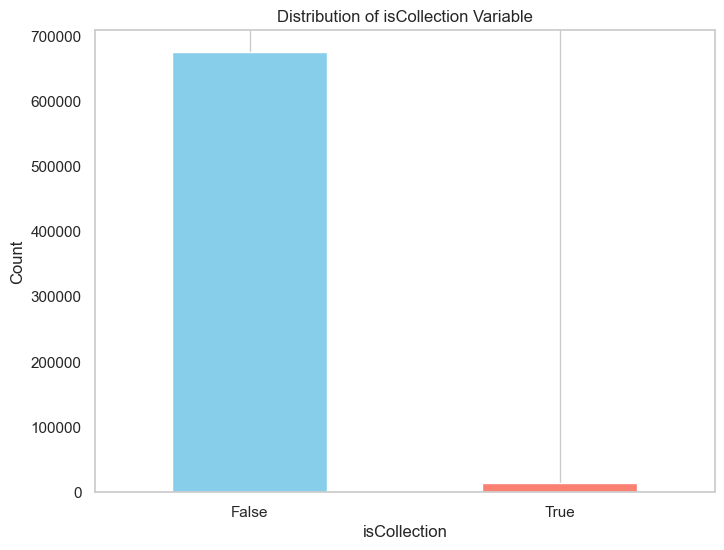

In [394]:
# Data
isCollection_counts = payment['isCollection'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
isCollection_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of isCollection Variable')
plt.xlabel('isCollection')
plt.ylabel('Count')
plt.xticks([0, 1], ['False', 'True'], rotation=0)
plt.grid(axis='y')
plt.show()

Within the pie chart, loans classified as "checked" and "complete" are categorized as good loans, while those labeled as "pending" and "rejected awaiting retry" fall under pending loans. "Cancelled," "skipped," and "returned" loans are considered bad loans. The distribution reveals that 55.6% of loans are categorized as bad, 42.5% as good, and 1.9% as pending.

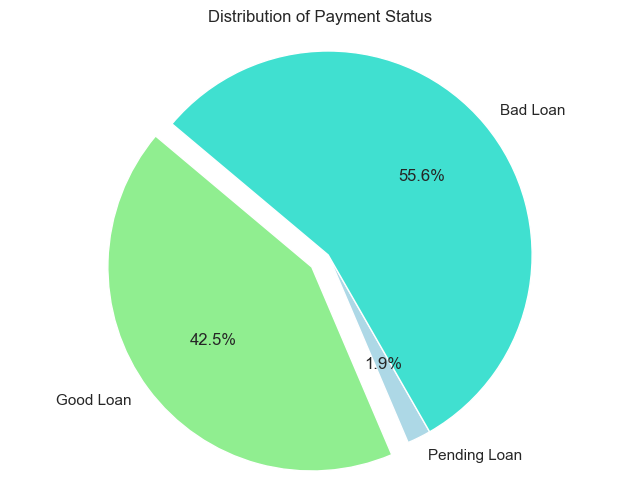

In [395]:
# Categorize payment statuses
good_loan_statuses = ['Checked', 'Complete']
pending_loan_statuses = ['Pending', 'Rejected Awaiting Retry']
bad_loan_statuses = ['Cancelled', 'Skipped', 'Returned']

# Count payments for each category
good_loan_count = sum(payment_status_data['count'][payment_status_data['paymentStatus'] == status].values[0] for status in good_loan_statuses)
pending_loan_count = sum(payment_status_data['count'][payment_status_data['paymentStatus'] == status].values[0] for status in pending_loan_statuses)
bad_loan_count = sum(payment_status_data['count'][payment_status_data['paymentStatus'] == status].values[0] for status in bad_loan_statuses)

# Create pie chart
labels = ['Good Loan', 'Pending Loan', 'Bad Loan']
sizes = [good_loan_count, pending_loan_count, bad_loan_count]
colors = ['lightgreen', 'lightblue', 'turquoise']
explode = (0.1, 0, 0)  # explode the 1st slice (Good Loan)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Payment Status')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

EDA (Underwriting)

In [396]:
underwriting.head()

,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudiden

In [397]:
# Read data
underwriting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 54 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   .underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago                                  49750 non-null  float64
 1   .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago                             49750 non-null  float64
 2   .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago                                   49750 non-null  float64
 3   .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago                                     49750 non-null  float64
 4   .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago                                  49750

In the underwriting dataset, the distribution of clear fraud scores exhibits a slight negative skewness,speculating the mean of the clear fraud scores is pulled towards the left, implying that the median value is likely the most appropriate choice for handling missing values in further sections.

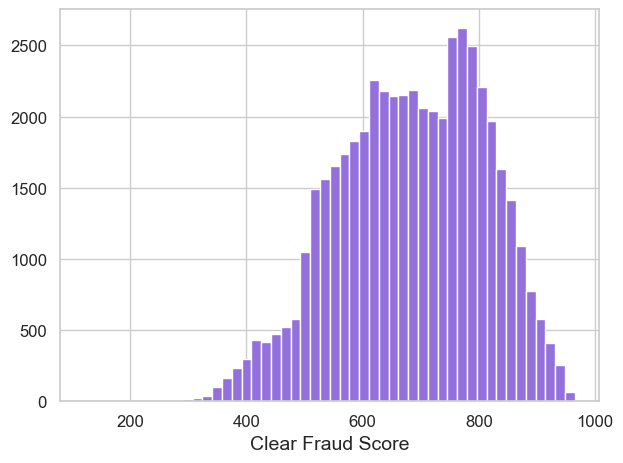

In [398]:
# Plot histogram of clearfraudscore
underwriting['clearfraudscore'].plot(kind='hist', bins=50, color='mediumpurple')
plt.xlabel('Clear Fraud Score', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In the correlation matrix provided, it's evident that the clear fraud score variable exhibits negative correlations with all other variables except for ".underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago". 

In [399]:
numeric_columns = underwriting.select_dtypes(include=['int64', 'bool', 'float64']).columns
underwriting_corr = underwriting[numeric_columns].corr()
underwriting_corr

,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore
.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,1.000000,0.510785,-0.218232,0.325573,0.786394,0.723825,0.117454,0.860943,0.477157,0.063049,0.037728,-0.015823,-0.473009
.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,0.510785,1.000000,-0.054307,0.764738,0.346722,0.784361,0.446901,0.647611,0.162105,0.047607,0.027167,0.009624,-0.282598
.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,-0.218232,-0.054307,1.000000,0.080820,-0.209709,-0.149575,0.357579,-0.188753,-0.177166,-0.049944,-0.024280,-0.003169,0.278027
.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,0.325573,0.764738,0.080820,1.000000,0.205327,0.558613,0.657633,0.440811,0.078283,0.044235,0.026793,0.015592,-0.182037
.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,0.786394,0.346722,-0.209709,0.205327,1.000000,0.524645,0.049018,0.641677,0.680162,0.062749,0.054695,-0.029294,-0.455191
.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,0.723825,0.784361,-0.149575,0.558613,0.524645,1.000000,0.285343,0.870878,0.283418,0.057031,0.029239,0.000384,-0.397889
.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,0.117454,0.446901,0.357579,0.657633,0.049018,0.285343,1.000000,0.199763,-0.018787,0.028186,0.016989,0.020352,-0.014151
.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,0.860943,0.647611,-0.188753,0.440811,0.641677,0.870878,0.199763,1.000000,0.370434,0.061862,0.033827,-0.008941,-0.454634
.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,0.477157,0.162105,-0.177166,0.078283,0.680162,0.283418,-0.018787,0.370434,1.000000,0.066022,0.075441,-0.043562,-0.362612
.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,0.063049,0.047607,-0.049944,0.044235,0.062749,0.057031,0.028186,0.061862,0.066022,1.000000,0.052515,0.157189,-0.228908


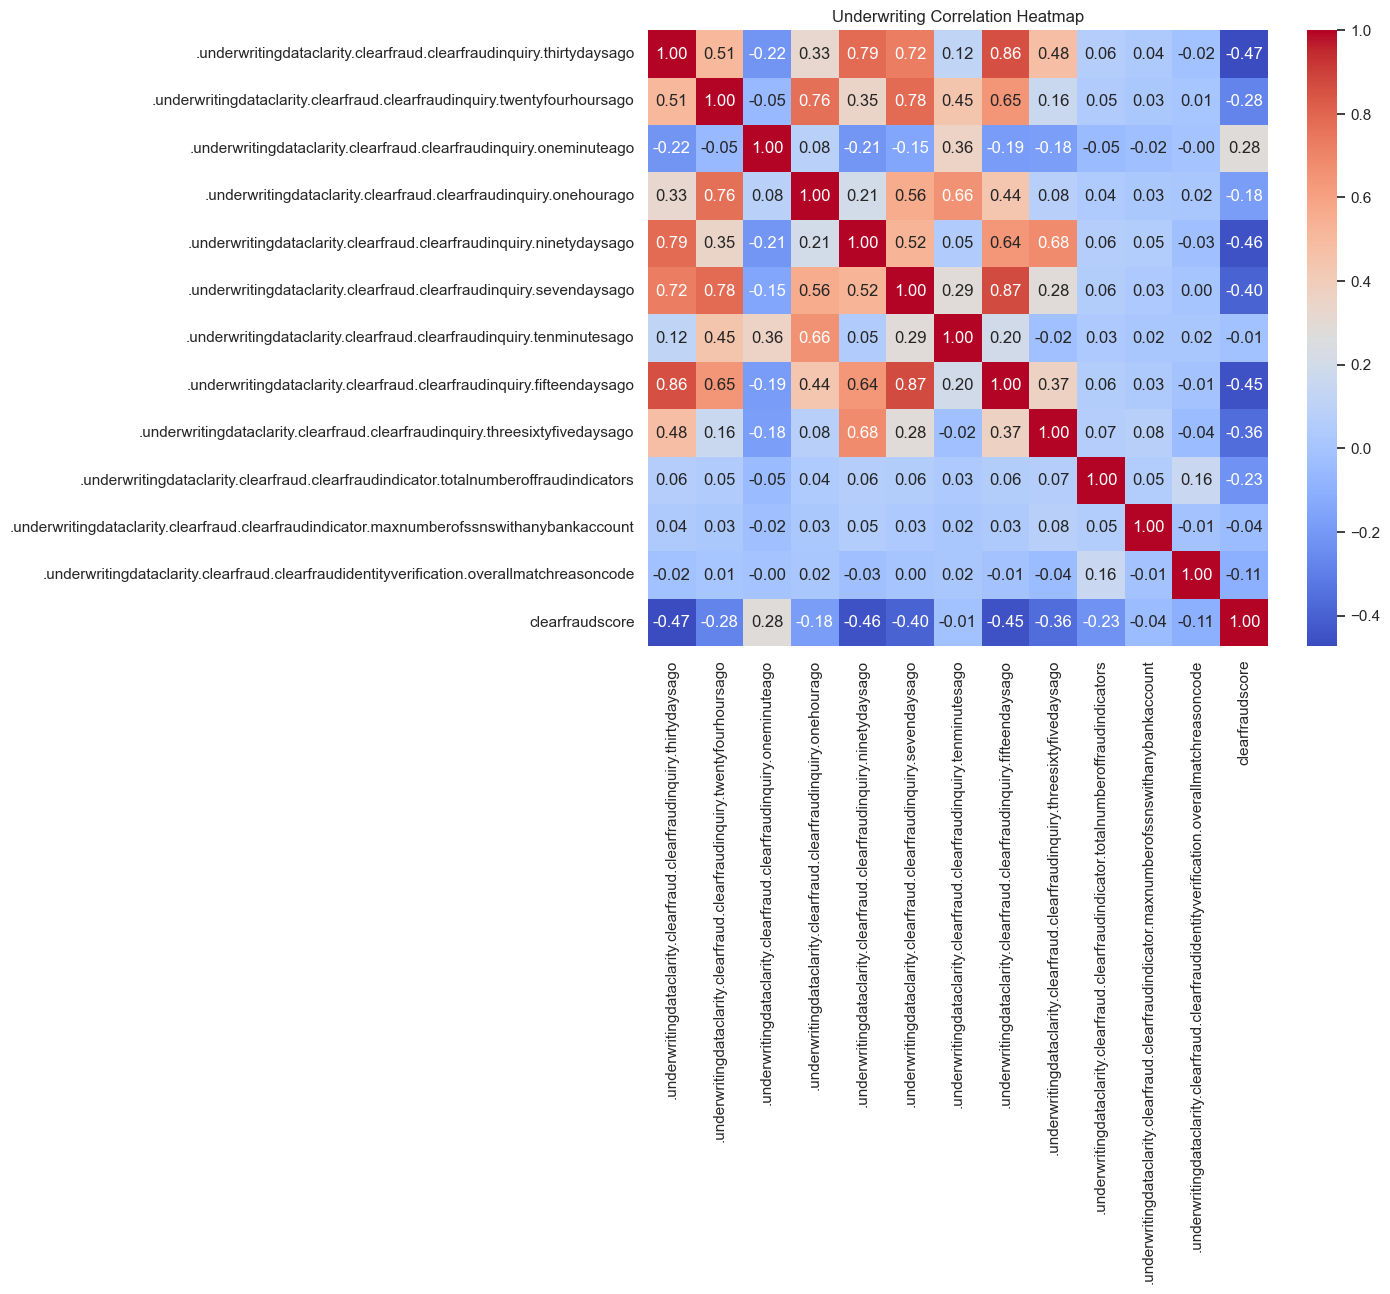

In [400]:
plt.figure(figsize=(10, 8))
sns.heatmap(underwriting_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Underwriting Correlation Heatmap')
plt.show()

Feature Engineering

For the loan_state variable, we apply one-hot encoding, a method that converts categorical values into numerical format. In this process, each unique state value becomes a separate binary feature. If the loan applicant is from a particular state, the corresponding feature is set to 1; otherwise, it's set to 0.

In [401]:
loan_state = pd.get_dummies(loan['state'], drop_first=True)
loan_state = loan_state.astype(int)
loan = pd.concat([loan.drop(columns=['state']), loan_state], axis=1)
loan

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadType,leadCost,fpStatus,clarityFraudId,hasCF,AL,AZ,CA,CO,CT,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MD,MI,MN,MO,MS,NC,ND,NE,NJ,NM,NV,NY,OH,OH-TEST,OK,PA,RI,SC,SD,TN,TX,TX-TEST,UT,VA,WA,WI,WY
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577677,LL-I-12122269,801262d04720d32040612759857f4147,B,590.0,2016-11-08T17:32:33.554000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1292.41,bvMandatory,3,NaN,58220cdde4b051c58d919c1f,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
577678,LL-I-16183462,e37750de9d99a67e0fa96a51e86fdf5b,S,490.0,2017-01-24T22:20:59.818000,False,NaN,0.0,False,0,Withdrawn Application,1000.0,2592.39,lead,25,NaN,5887d349e4b08f249ac45e2f,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
577679,LL-I-06962710,d7e55e85266208ac4c353f42ebcde5ca,B,590.0,2016-02-02T03:05:47.797000,False,NaN,0.0,False,0,Withdrawn Application,300.0,844.75,bvMandatory,6,NaN,550b1f59e4b0d4592e28c84e,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
577680,LL-I-01253468,c3b35307cb36116bf59574f9138d3dad,B,550.0,2015-05-21T20:19:49.639000,False,NaN,0.0,False,0,Withdrawn Application,300.0,770.80,organic,6,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We'll use one-hot encoding for the loan_status variable, categorizing statuses into two groups: high default rate (encoded as 0) and low default rate (encoded as 1). "Settled Bankruptcy," "Charged Off," and "Rejected" will be labeled 0, while "Paid Off Loan" and "Settlement Paid Off" will be labeled 1. Other statuses will be encoded as NaN for further preprocessing.

In [402]:
# Perform a normalized count of unique values in loanStatus
loan_status = (loan['loanStatus'].value_counts(normalize=True) * 100).round(2).astype(str) + '%'
loan_status

loanStatus
Withdrawn Application          78.12%
Rejected                       14.74%
Paid Off Loan                   1.98%
External Collection             1.96%
New Loan                        1.41%
Internal Collection             0.96%
Returned Item                    0.2%
CSR Voided New Loan             0.18%
Settlement Paid Off             0.12%
Credit Return Void              0.12%
Customer Voided New Loan        0.09%
Settled Bankruptcy              0.06%
Pending Paid Off                0.03%
Charged Off Paid Off            0.03%
Pending Application Fee          0.0%
Pending Rescind                  0.0%
Pending Application              0.0%
Voided New Loan                  0.0%
Charged Off                      0.0%
Customver Voided New Loan        0.0%
Settlement Pending Paid Off      0.0%
Name: proportion, dtype: object

In [403]:
# Map loan status to target (0: loan default, 1: loan didn't default)
def target_encoding(x):
    labels = {0: ['Settled Bankruptcy', 'Charged Off', 'Rejected'],
              1: ['Paid Off Loan', 'Settlement Paid Off']}
    for label, statuses in labels.items():
        if x in statuses:
            return label

loan['target'] = loan['loanStatus'].map(target_encoding)

# Replace NaN values in 'target' column with a blank string
loan['target'].replace('', np.nan, inplace=True)

# Get the target value counts
target_counts = loan['target'].value_counts()
target_counts

target
0.0    85397
1.0    12135
Name: count, dtype: int64

In [404]:
# Map loan statuses to categories
loan['loanStatus'] = loan['loanStatus'].map(target_encoding)

# Rename the newly created column as 'loanStatus'
loan.rename(columns={'loanStatus': 'loanStatus'}, inplace=True)

The bar plot of the loan status variable revealed that 87.56% (85,397 people) fell into the high default category, while 12.44% (12,135 people) were classified as low default.

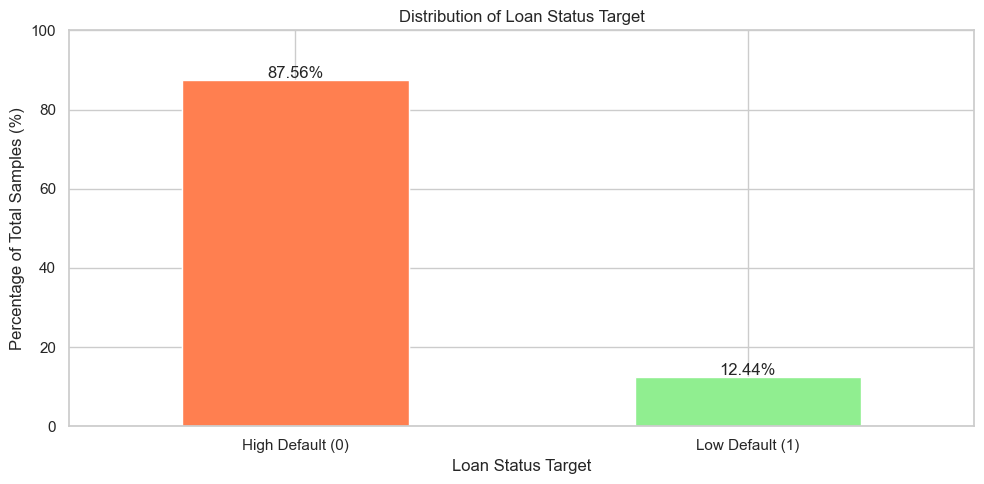

In [405]:
# Calculate the total number of samples
total_samples = target_counts.sum()

# Calculate the percentage of each target value
target_percentage = target_counts / total_samples * 100

# Define colors
colors = ['coral', 'lightgreen']

# Create a bar plot
plt.figure(figsize=(10, 5))
target_percentage.plot(kind='bar', color=colors)
ax = target_percentage.plot(kind='bar', color=colors)


# Add labels and title
plt.xlabel('Loan Status Target')
plt.ylabel('Percentage of Total Samples (%)')
plt.title('Distribution of Loan Status Target')

# Add percentages on top of the bars
for i, percentage in enumerate(target_percentage):
    ax.text(i, percentage + 0.5, f'{percentage:.2f}%', ha='center', fontsize=12)

# Set x-tick labels and rotate them
ax.set_xticklabels(['High Default (0)', "Low Default (1)"], rotation=0)

# Set y-axis limit to 100%
plt.ylim(0, 100)

# Show plot
plt.tight_layout()
plt.show()

For payment status, rejected was coded as 0 and approved as 1. Here, 0 represents high default possibilities, while 1 represents low default possibilities.

In [406]:
# Map loan status to target (0: loan default, 1: loan didn't default)
def encode(x):
    labels = {0: ['Rejected'],
              1: ['Checked']}
    for label, statuses in labels.items():
        if x in statuses:
            return label

payment['target'] = payment['paymentStatus'].map(encode)

# Replace NaN values in 'target' column with a blank string
payment['target'].replace('', np.nan, inplace=True)

# Get the target value counts
target_counts = payment['target'].value_counts()
target_counts

target
1.0    209621
0.0     32330
Name: count, dtype: int64

In [407]:
# Map loan statuses to categories
payment['paymentStatus'] = payment['paymentStatus'].map(encode)

# Rename the newly created column as 'loanStatus'
payment.rename(columns={'paymentStatus': 'paymentStatus'}, inplace=True)

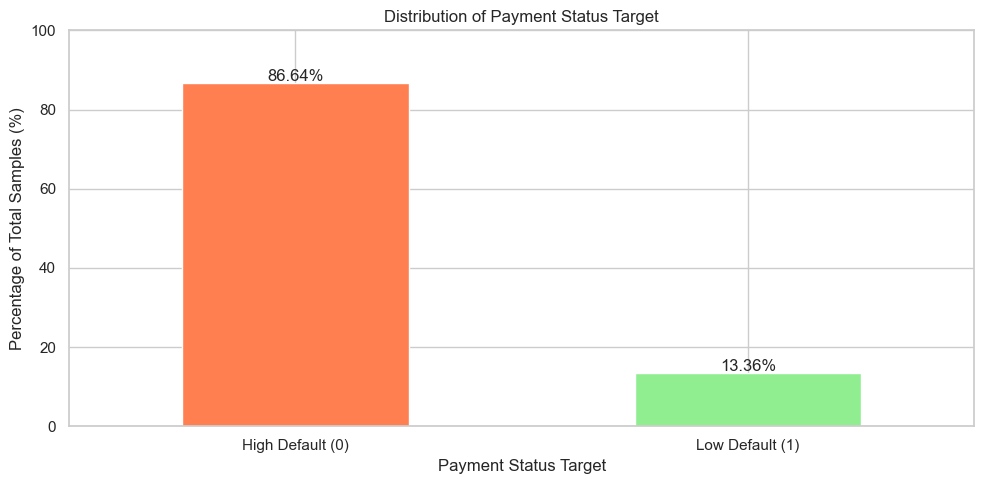

In [408]:
# Calculate the total number of samples
total_samples = target_counts.sum()

# Calculate the percentage of each target value
target_percentage = target_counts / total_samples * 100

# Define colors
colors = ['coral', 'lightgreen']

# Create a bar plot
plt.figure(figsize=(10, 5))
ax = target_percentage.plot(kind='bar', color=colors)

# Add labels and title
plt.xlabel('Payment Status Target')
plt.ylabel('Percentage of Total Samples (%)')
plt.title('Distribution of Payment Status Target')

# Add percentages on top of the bars
for i, percentage in enumerate(target_percentage):
    ax.text(i, percentage + 0.5, f'{percentage:.2f}%', ha='center', fontsize=12)

# Set x-tick labels and rotate them
ax.set_xticklabels(['High Default (0)', "Low Default (1)"], rotation=0)

# Set y-axis limit to 100%
plt.ylim(0, 100)

# Show plot
plt.tight_layout()
plt.show()

Merge DataSet

Here, we combine selected columns from the loan dataframe with columns from the underwriting dataframe based on a shared identifier, creating a new dataframe.

In [409]:
underwriting = underwriting[['underwritingid', 'clearfraudscore']]

df = pd.merge(loan, underwriting,left_on='clarityFraudId', right_on='underwritingid')
df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadType,leadCost,fpStatus,clarityFraudId,hasCF,AL,AZ,CA,CO,CT,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MD,MI,MN,MO,MS,NC,ND,NE,NJ,NM,NV,NY,OH,OH-TEST,OK,PA,RI,SC,SD,TN,TX,TX-TEST,UT,VA,WA,WI,WY,target,underwritingid,clearfraudscore
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,1.0,3000.0,6395.19,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,569eb3a3e4b096699f685d64,879.0
1,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,True,2017-03-01T16:15:13.016000,0.0,True,1,NaN,400.0,1364.87,lead,40,Checked,58b6eef8e4b0b6fca82fd426,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,58b6eef8e4b0b6fca82fd426,658.0
2,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,True,2017-01-31T18:00:14.520000,2.0,True,1,1.0,1250.0,3313.78,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,58450a15e4b0bb9d6d7344c7,835.0
3,LL-I-17491287,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-02-21T17:20:23.671000,True,2017-02-21T17:45:11.088000,3.0,True,1,1.0,1250.0,3112.16,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,58450a15e4b0bb9d6d7344c7,835.0
4,LL-I-15679301,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-18T01:16:24.941000,True,2017-01-18T01:30:16.712000,1.0,True,1,1.0,500.0,1292.09,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,58450a15e4b0bb9d6d7344c7,835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36329,LL-I-17508871,f0b666fdd1b46c58297b3828b61047ad,M,180.2,2017-02-21T20:29:57.538000,True,2017-02-21T20:45:06.563000,0.0,True,1,NaN,500.0,794.60,lead,25,Rejected,58aca342e4b0bf804c0e82db,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,58aca342e4b0bf804c0e82db,695.0
36330,LL-I-15280684,73690518af906288434b2a0cfd972fe0,M,645.0,2017-01-14T19:43:08.685000,True,2017-01-14T20:00:10.426000,0.0,True,1,1.0,375.0,1042.40,lead,25,Checked,587a7f49e4b08f2485d48358,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,587a7f49e4b08f2485d48358,700.0
36331,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,B,449.0,2016-06-22T01:10:50.110000,True,2016-06-22T21:46:54.359000,0.0,True,1,1.0,400.0,664.12,lead,40,Checked,5769e592e4b0ab6c50364d45,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,5769e592e4b0ab6c50364d45,806.0
36332,LL-I-14178923,d9a63e9e15b862fcaaf3653c52e1f16c,B,625.0,2016-12-30T15:49:39.785000,True,2016-12-30T16:00:12.500000,0.0,True,1,NaN,600.0,1868.88,lead,25,Checked,58668211e4b08f246e282356,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,58668211e4b08f246e282356,769.0


In [410]:
df.columns

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
       'originated', 'originatedDate', 'nPaidOff', 'approved', 'isFunded',
       'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount',
       'leadType', 'leadCost', 'fpStatus', 'clarityFraudId', 'hasCF', 'AL',
       'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN',
       'KS', 'KY', 'LA', 'MD', 'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NE', 'NJ',
       'NM', 'NV', 'NY', 'OH', 'OH-TEST', 'OK', 'PA', 'RI', 'SC', 'SD', 'TN',
       'TX', 'TX-TEST', 'UT', 'VA', 'WA', 'WI', 'WY', 'target',
       'underwritingid', 'clearfraudscore'],
      dtype='object')

Data Transformation

In the data transformation step, we remove certain variables from the dataset that we believe are not relevant for our model, in order to avoid redundancy.

In [411]:
df.drop(['loanId', 'isFunded', 'loanStatus', 'fpStatus','anon_ssn','payFrequency', 'apr','applicationDate','originated','originatedDate','leadType', 'clarityFraudId','applicationDate', 'originallyScheduledPaymentAmount','leadCost', 'hasCF', 'underwritingid','target'], axis=1, inplace=True)

In [412]:
df.columns

Index(['nPaidOff', 'approved', 'loanAmount', 'AL', 'AZ', 'CA', 'CO', 'CT',
       'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MD',
       'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NE', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OH-TEST', 'OK', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'TX-TEST', 'UT',
       'VA', 'WA', 'WI', 'WY', 'clearfraudscore'],
      dtype='object')

By providing the total count and percentage of missing values for each column, it offers insights into data completeness and informs us about the potential need for data imputation.

In [413]:
def check_nan(df):
    """
    Compute the percentage of missing values in each column of a DataFrame.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to check for missing values
        
    Returns:
        pandas.Series: A Series containing the percentage of missing values in each column.
    """
    total = df.isnull().sum()
    percent = (df.isnull().mean() * 100).round(2)
    missing_data = pd.DataFrame({'Total Missing': total, 'Percentage Missing': percent})
    return missing_data

In [414]:
missing_data = check_nan(df)
print(missing_data)

                 Total Missing  Percentage Missing
nPaidOff                     2                0.01
approved                     0                0.00
loanAmount                  17                0.05
AL                           0                0.00
AZ                           0                0.00
CA                           0                0.00
CO                           0                0.00
CT                           0                0.00
DE                           0                0.00
FL                           0                0.00
GA                           0                0.00
HI                           0                0.00
IA                           0                0.00
ID                           0                0.00
IL                           0                0.00
IN                           0                0.00
KS                           0                0.00
KY                           0                0.00
LA                           0 

Data is peaked from 0 - 500 dollar in terms of loan amount, speculating that the mode value is likely the most appropriate choice for handling missing values.

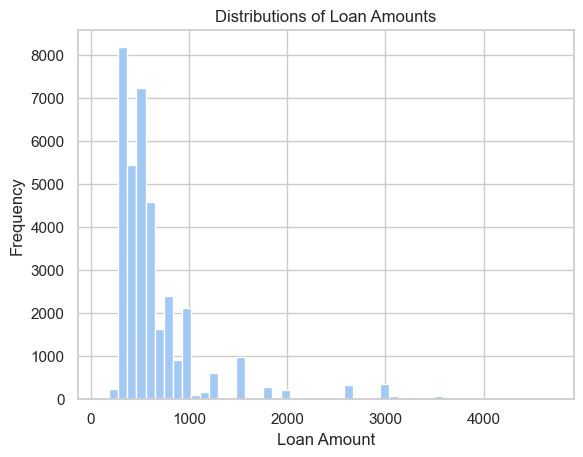

In [415]:
df['loanAmount'].hist(bins=50)
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distributions of Loan Amounts')
plt.show()

Data is highly concentrated around zero, indicating that the mode value is likely the most appropriate choice for handling missing values.

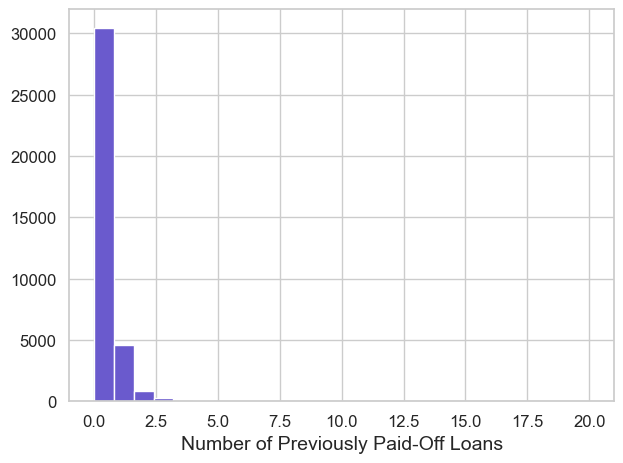

In [416]:
# Plot histogram of nPaidOff
df['nPaidOff'].plot(kind='hist', bins=25, color='slateblue')
plt.xlabel('Number of Previously Paid-Off Loans', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [417]:
# Fill missing values
df.loc[df['clearfraudscore'].isna(), 'clearfraudscore'] = df['clearfraudscore'].median()
df.loc[df['nPaidOff'].isna(), 'nPaidOff'] = df['nPaidOff'].mode()[0]
df.loc[df['loanAmount'].isna(), 'loanAmount'] = df['loanAmount'].mode()[0]

In [418]:
df.isnull().sum()

nPaidOff           0
approved           0
loanAmount         0
AL                 0
AZ                 0
CA                 0
CO                 0
CT                 0
DE                 0
FL                 0
GA                 0
HI                 0
IA                 0
ID                 0
IL                 0
IN                 0
KS                 0
KY                 0
LA                 0
MD                 0
MI                 0
MN                 0
MO                 0
MS                 0
NC                 0
ND                 0
NE                 0
NJ                 0
NM                 0
NV                 0
NY                 0
OH                 0
OH-TEST            0
OK                 0
PA                 0
RI                 0
SC                 0
SD                 0
TN                 0
TX                 0
TX-TEST            0
UT                 0
VA                 0
WA                 0
WI                 0
WY                 0
clearfraudscore    0
dtype: int64

Feature Scaling

To address numerical instability concerns, we normalize or scale numerical variables. Min-max scaling is utilized for features that contain outliers to ensure consistency across the dataset.

In [419]:
scaler = MinMaxScaler()
df[['loanAmount']] = scaler.fit_transform(df[['loanAmount']])

print(df[['loanAmount']])

       loanAmount
0        0.632153
1        0.065395
2        0.250681
3        0.250681
4        0.087193
...           ...
36329    0.087193
36330    0.059946
36331    0.065395
36332    0.108992
36333    0.043597

[36334 rows x 1 columns]


In [420]:
df

,nPaidOff,approved,loanAmount,AL,AZ,CA,CO,CT,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MD,MI,MN,MO,MS,NC,ND,NE,NJ,NM,NV,NY,OH,OH-TEST,OK,PA,RI,SC,SD,TN,TX,TX-TEST,UT,VA,WA,WI,WY,clearfraudscore
0,0.0,True,0.632153,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,879.0
1,0.0,True,0.065395,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,658.0
2,2.0,True,0.250681,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,835.0
3,3.0,True,0.250681,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,835.0
4,1.0,True,0.087193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36329,0.0,True,0.087193,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,695.0
36330,0.0,True,0.059946,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,700.0
36331,0.0,True,0.065395,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,806.0
36332,0.0,True,0.108992,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,769.0


Assigning Variables and Train-Test Split

We select 'clearfraudscore', 'nPaidOff', and 'loanAmount' as input features, with 'isApproved' as the output variable. The exclusion of states from the modeling section will be elaborated on later.

In [421]:
input_features = ['clearfraudscore','nPaidOff', 'loanAmount']
x=df[input_features]
y=df.approved

In [422]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)


In the modeling phase, we utilize 5 machine learning algorithms on our dataset: logistic regression, decision trees, support vector machines, k-nearest-neighbors, and random forest algorithms.

Modeling (Logistic Regression)

In [423]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(x_train, y_train)
y_pred=model.predict(x_test)

Evaluation Metrics

Confusion Matrix:
 [[  17  791]
 [  38 6421]]
Accuracy Score in Percentage: 88.59%
Precision in Percentage: 89.03%
Recall in Percentage: 99.41%
F1-Score in Percentage: 93.94%

Classification Report:
               precision    recall  f1-score   support

       False       0.31      0.02      0.04       808
        True       0.89      0.99      0.94      6459

    accuracy                           0.89      7267
   macro avg       0.60      0.51      0.49      7267
weighted avg       0.83      0.89      0.84      7267



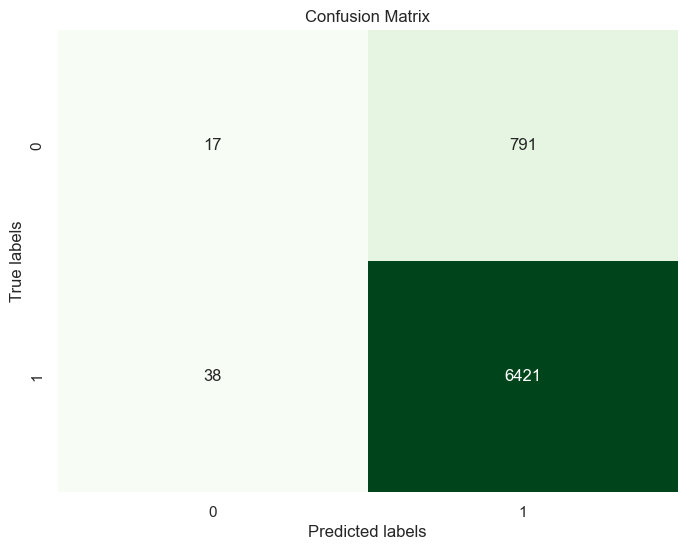

In [425]:
# Calculate and print the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_mat)

# Calculate and print the accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_score_percentage = accuracy * 100
print('Accuracy Score in Percentage: {:.2f}%'.format(accuracy_score_percentage))

# Calculate and print the precision, recall, and F1-score
precision = metrics.precision_score(y_test, y_pred)
precision_percentage = precision * 100
print('Precision in Percentage: {:.2f}%'.format(precision_percentage))

recall = metrics.recall_score(y_test, y_pred)
recall_percentage = recall * 100
print('Recall in Percentage: {:.2f}%'.format(recall_percentage))

f1 = metrics.f1_score(y_test, y_pred)
f1_percentage = f1 * 100
print('F1-Score in Percentage: {:.2f}%'.format(f1_percentage))

# Generate classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Modeling (Decision Tree)

In [426]:
model = DecisionTreeClassifier(criterion='entropy', random_state=5)
model.fit(x_train, y_train)
y_pred=model.predict(x_test)

Evaluation Metrics

Confusion Matrix:
 [[ 209  599]
 [ 387 6072]]
Accuracy Score in Percentage: 86.43%
Precision in Percentage: 91.02%
Recall in Percentage: 94.01%
F1-Score in Percentage: 92.49%

Classification Report:
               precision    recall  f1-score   support

       False       0.35      0.26      0.30       808
        True       0.91      0.94      0.92      6459

    accuracy                           0.86      7267
   macro avg       0.63      0.60      0.61      7267
weighted avg       0.85      0.86      0.86      7267



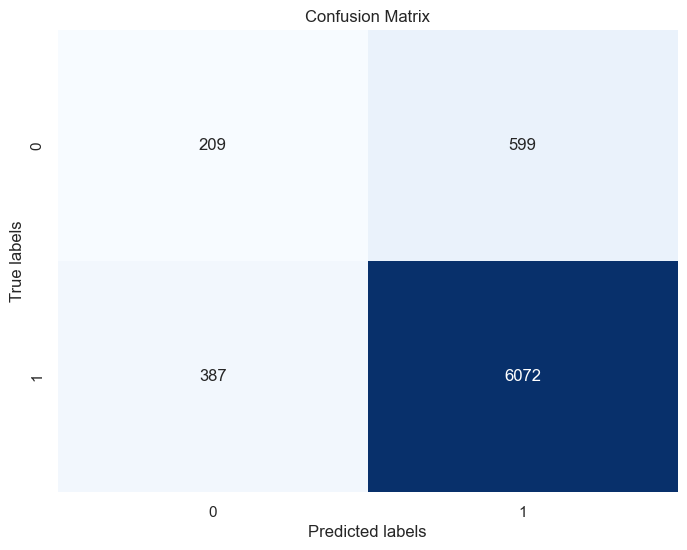

In [427]:
# Calculate and print the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_mat)

# Calculate and print the accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_score_percentage = accuracy * 100
print('Accuracy Score in Percentage: {:.2f}%'.format(accuracy_score_percentage))

# Calculate and print the precision, recall, and F1-score
precision = metrics.precision_score(y_test, y_pred)
precision_percentage = precision * 100
print('Precision in Percentage: {:.2f}%'.format(precision_percentage))

recall = metrics.recall_score(y_test, y_pred)
recall_percentage = recall * 100
print('Recall in Percentage: {:.2f}%'.format(recall_percentage))

f1 = metrics.f1_score(y_test, y_pred)
f1_percentage = f1 * 100
print('F1-Score in Percentage: {:.2f}%'.format(f1_percentage))

# Generate classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Modeling (Support Vector Machine[Linear])

In [428]:
model = SVC(kernel='linear', random_state=5)
model.fit(x_train, y_train)
svc_prediction = model.predict(x_test)

Confusion Matrix:
 [[  11  797]
 [  15 6444]]
Accuracy Score in Percentage: 88.83%
Precision in Percentage: 88.99%
Recall in Percentage: 99.77%
F1-Score in Percentage: 94.07%

Classification Report:
               precision    recall  f1-score   support

       False       0.01      0.42      0.03        26
        True       1.00      0.89      0.94      7241

    accuracy                           0.89      7267
   macro avg       0.51      0.66      0.48      7267
weighted avg       0.99      0.89      0.94      7267



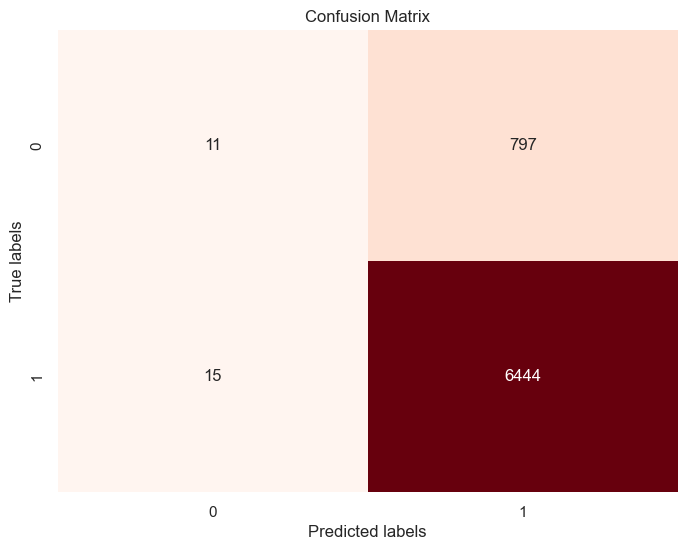

In [429]:
# Calculate and print the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, svc_prediction)
print('Confusion Matrix:\n', conf_mat)

# Calculate and print the accuracy score
accuracy_score = metrics.accuracy_score(y_test, svc_prediction)
accuracy_score_percentage = accuracy_score * 100
print('Accuracy Score in Percentage: {:.2f}%'.format(accuracy_score_percentage))

# Calculate and print the precision, recall, and F1-score
precision = metrics.precision_score(y_test, svc_prediction)
precision_percentage = precision * 100
print('Precision in Percentage: {:.2f}%'.format(precision_percentage))

recall = metrics.recall_score(y_test, svc_prediction)
recall_percentage = recall * 100
print('Recall in Percentage: {:.2f}%'.format(recall_percentage))

f1 = metrics.f1_score(y_test, svc_prediction)
f1_percentage = f1 * 100
print('F1-Score in Percentage: {:.2f}%'.format(f1_percentage))

# Generate classification report
print('\nClassification Report:\n', classification_report(svc_prediction,y_test))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Modeling (k-Nearest Neighbors)

In [430]:
results = []
for i in [1,2,3,4,5]:
    model = KNeighborsClassifier(n_neighbors=i, metric='minkowski', p=2)
    model.fit(x_train, y_train)
    y_pred=model.predict(x_test)

Evaluation Metrics

Confusion Matrix:
 [[ 124  684]
 [ 164 6295]]
Accuracy Score in Percentage: 88.83%
Precision in Percentage: 90.20%
Recall in Percentage: 97.46%
F1-Score in Percentage: 93.69%

Classification Report:
               precision    recall  f1-score   support

       False       0.43      0.15      0.23       808
        True       0.90      0.97      0.94      6459

    accuracy                           0.88      7267
   macro avg       0.67      0.56      0.58      7267
weighted avg       0.85      0.88      0.86      7267



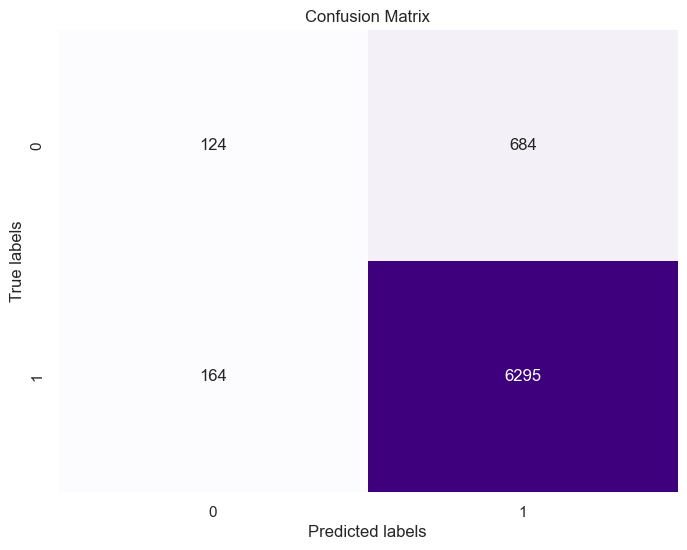

In [431]:
# Calculate and print the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_mat)

# Calculate and print the accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_score_percentage = accuracy_score * 100
print('Accuracy Score in Percentage: {:.2f}%'.format(accuracy_score_percentage))

# Calculate and print the precision, recall, and F1-score
precision = metrics.precision_score(y_test, y_pred)
precision_percentage = precision * 100
print('Precision in Percentage: {:.2f}%'.format(precision_percentage))

recall = metrics.recall_score(y_test, y_pred)
recall_percentage = recall * 100
print('Recall in Percentage: {:.2f}%'.format(recall_percentage))

f1 = metrics.f1_score(y_test, y_pred)
f1_percentage = f1 * 100
print('F1-Score in Percentage: {:.2f}%'.format(f1_percentage))

# Generate classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Modeling (Random Forest)

In [432]:
model = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=10)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

Evaluation Metrics

Confusion Matrix:
 [[ 164  644]
 [ 284 6175]]
Accuracy Score in Percentage: 88.83%
Precision in Percentage: 90.56%
Recall in Percentage: 95.60%
F1-Score in Percentage: 93.01%

Classification Report:
               precision    recall  f1-score   support

       False       0.37      0.20      0.26       808
        True       0.91      0.96      0.93      6459

    accuracy                           0.87      7267
   macro avg       0.64      0.58      0.60      7267
weighted avg       0.85      0.87      0.86      7267



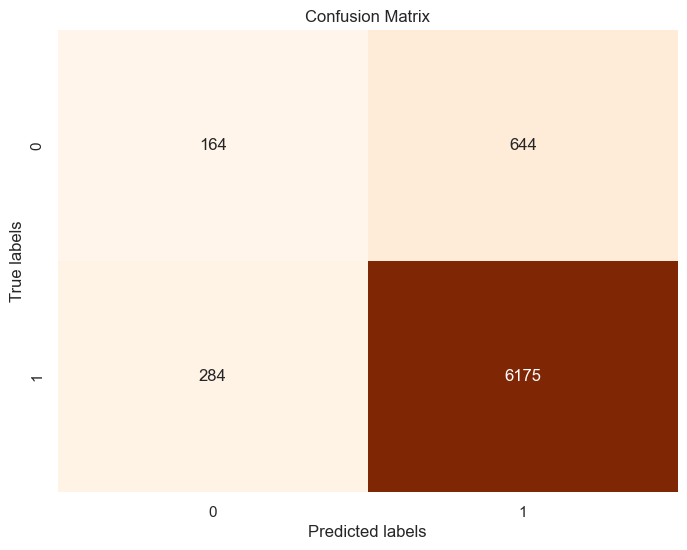

In [433]:
# Calculate and print the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_mat)

# Calculate and print the accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_score_percentage = accuracy_score * 100
print('Accuracy Score in Percentage: {:.2f}%'.format(accuracy_score_percentage))

# Calculate and print the precision, recall, and F1-score
precision = metrics.precision_score(y_test, y_pred)
precision_percentage = precision * 100
print('Precision in Percentage: {:.2f}%'.format(precision_percentage))

recall = metrics.recall_score(y_test, y_pred)
recall_percentage = recall * 100
print('Recall in Percentage: {:.2f}%'.format(recall_percentage))

f1 = metrics.f1_score(y_test, y_pred)
f1_percentage = f1 * 100
print('F1-Score in Percentage: {:.2f}%'.format(f1_percentage))

# Generate classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Summaries (Modelling)

Overall, all models performed similarly in terms of accuracy, with an accuracy score of 88.83%. When it comes to precision, decision trees and random forest achieved the highest precision scores of 91.02% and 90.56%, respectively. However, support vector machine (SVM) had the highest recall score of 99.77%, indicating its ability to correctly identify most positive instances. In terms of the F1-score, SVM also outperformed other models with a score of 94.07%, followed closely by decision trees with a score of 92.49%. These results suggest that SVM may be the most suitable model for this classification task, considering its balanced performance in both precision and recall.

Conclusions

One valuable insight from this data science project is its potential deployment as an initial screening tool for loan applications. By utilizing the predictive model developed in this project, it is possible that MoneyLion can streamline the first round of loan application assessments using auto moderation. This approach is potentially able to reduce manpower costs and workloads associated with manual reviews, leading to increased operational efficiency and faster processing times for loan applicants.

Additionally, the project's focus on features like 'clearfraudscore', 'nPaidOff', and 'loanAmount' highlights its relevance in fraud detection within the loan approval process. We focused on predicting loan risk or quality based on selected variables: 'clearfraudscore', 'nPaidOff', and 'loanAmount', with the output being loan approval status. We intentionally removed the state of loan applicants as input features because it lacked specificity in assessing risk due to variations in economic power among different states' residents. This improved fraud detection capability not only helps mitigate financial losses but also fosters greater trust and confidence among lenders and borrowers alike.

The limitations that we face include the exclusion of payment data from the modelling phase, as we found that the variables within the payment file primarily focus on outcomes rather than the loan process itself. We conducted several experiments. For instance, when we attempted to incorporate "paymentStatus" as a variable, we observed that the "approved" field in the loan dataframe turns into one option, namely "true," with no "false" values. Consequently, in this scenario, we must choose between 'approved' and 'paymentStatus' variables in the modelling phase, considering alternative courses of action. This decision was made to prioritize understanding the loan approval process rather than focusing on post-approval payment outcomes.

Moving forward, we wish to provide a solid foundation for optimizing loan risk assessment processes, paving the way for more informed decision-making and ultimately empowering MoneyLion to better serve its customers and thrive in the dynamic landscape of financial services.